In [21]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1. Load Data Mentah (Raw)

In [22]:
# Load raw data
data = pd.read_csv('../data/raw/data_capstone.csv')

print(f"Dataset shape: {data.shape}")
print(f"\nFirst 5 rows:")
print(data.head())
print(f"\nColumn names:")
print(data.columns.tolist())
print(f"\nData types:")
print(data.dtypes)
print(f"\nMissing values:")
print(data.isnull().sum())
print(f"\nTarget distribution:")
print(data['target_offer'].value_counts())

Dataset shape: (10000, 12)

First 5 rows:
  customer_id plan_type device_brand  avg_data_usage_gb  pct_video_usage  \
0      C00001   Prepaid       Realme               1.50         0.804146   
1      C00002  Postpaid         Vivo               1.09         0.107686   
2      C00003  Postpaid       Xiaomi               3.24         0.313894   
3      C00004   Prepaid        Apple               5.32         0.420158   
4      C00005   Prepaid       Huawei               1.91         0.251638   

   avg_call_duration  sms_freq  monthly_spend  topup_freq  travel_score  \
0               7.98        13        70000.0           4      0.284419   
1               9.56         9        63000.0           3      0.115086   
2               4.61        13        89000.0           7      0.402998   
3               6.96         8        67000.0           4      0.302169   
4              11.01        21        72000.0           5      0.487911   

   complaint_count   target_offer  
0             

## 2. Preprocessing dan Encoding

In [23]:
# Encode target_offer ke numerik
le = LabelEncoder()
data['target'] = le.fit_transform(data['target_offer'])

print("Target encoding:")
for i, label in enumerate(le.classes_):
    print(f"  {label}: {i}")

# One-hot encoding untuk categorical variables
data_encoded = pd.get_dummies(data, columns=['plan_type', 'device_brand'], drop_first=False)

# Drop kolom yang tidak diperlukan
data_encoded = data_encoded.drop(['customer_id', 'target_offer'], axis=1)

print(f"\nShape after encoding: {data_encoded.shape}")
print(f"\nEncoded columns:")
for i, col in enumerate(data_encoded.columns, 1):
    print(f"  {i}. {col}")

Target encoding:
  Data Booster: 0
  Device Upgrade Offer: 1
  Family Plan Offer: 2
  General Offer: 3
  Retention Offer: 4
  Roaming Pass: 5
  Streaming Partner Pack: 6
  Top-up Promo: 7
  Voice Bundle: 8

Shape after encoding: (10000, 18)

Encoded columns:
  1. avg_data_usage_gb
  2. pct_video_usage
  3. avg_call_duration
  4. sms_freq
  5. monthly_spend
  6. topup_freq
  7. travel_score
  8. complaint_count
  9. target
  10. plan_type_Postpaid
  11. plan_type_Prepaid
  12. device_brand_Apple
  13. device_brand_Huawei
  14. device_brand_Oppo
  15. device_brand_Realme
  16. device_brand_Samsung
  17. device_brand_Vivo
  18. device_brand_Xiaomi


## 3. Split Data dan Prepare Features

In [24]:
# Separate features and target
X = data_encoded.drop('target', axis=1)
y = data_encoded['target']
feature_names = X.columns.tolist()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {len(feature_names)}")
print(f"\nFeature names (ASLI):")
for i, feat in enumerate(feature_names, 1):
    print(f"  {i}. {feat}")

Training samples: 8000
Test samples: 2000
Number of features: 17

Feature names (ASLI):
  1. avg_data_usage_gb
  2. pct_video_usage
  3. avg_call_duration
  4. sms_freq
  5. monthly_spend
  6. topup_freq
  7. travel_score
  8. complaint_count
  9. plan_type_Postpaid
  10. plan_type_Prepaid
  11. device_brand_Apple
  12. device_brand_Huawei
  13. device_brand_Oppo
  14. device_brand_Realme
  15. device_brand_Samsung
  16. device_brand_Vivo
  17. device_brand_Xiaomi


## 4. Analisis Korelasi dengan Target


=== Top 10 Features berdasarkan Korelasi ===
                Feature  Correlation  Percentage
0         monthly_spend     0.551102       27.75
1     avg_data_usage_gb     0.490896       24.71
2    device_brand_Apple     0.094638        4.76
3   device_brand_Huawei     0.088417        4.45
4   device_brand_Realme     0.087166        4.39
5   device_brand_Xiaomi     0.081070        4.08
6     device_brand_Vivo     0.074408        3.75
7       complaint_count     0.073691        3.71
8  device_brand_Samsung     0.069121        3.48
9            topup_freq     0.062648        3.15


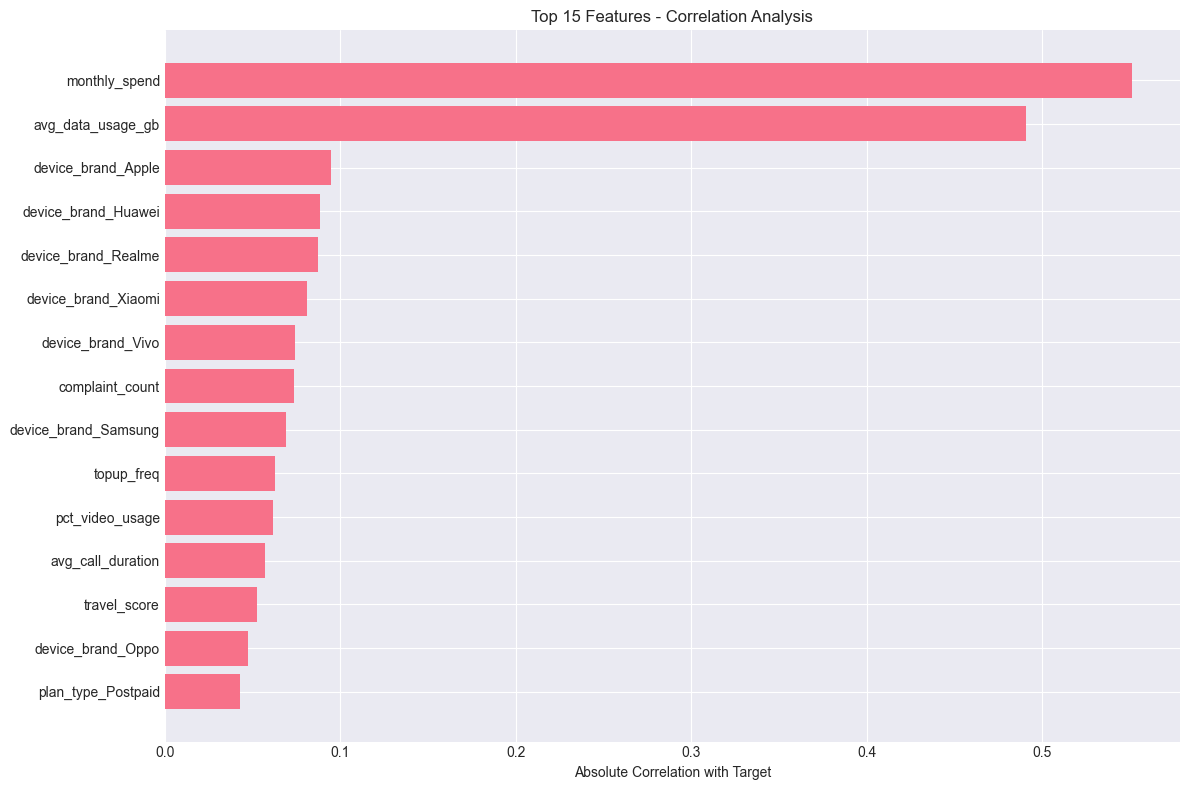

In [25]:
# Hitung korelasi setiap fitur dengan target
correlations = X.corrwith(y).abs().sort_values(ascending=False)

# Buat DataFrame untuk korelasi
corr_df = pd.DataFrame({
    'Feature': correlations.index,
    'Correlation': correlations.values,
    'Percentage': (correlations.values / correlations.sum() * 100).round(2)
})

print("\n=== Top 10 Features berdasarkan Korelasi ===")
print(corr_df.head(10))

# Visualisasi
plt.figure(figsize=(12, 8))
plt.barh(corr_df['Feature'][:15], corr_df['Correlation'][:15])
plt.xlabel('Absolute Correlation with Target')
plt.title('Top 15 Features - Correlation Analysis')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

## 5. Random Forest Feature Importance

In [26]:
# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Get feature importances
rf_importances = rf_model.feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances,
    'Percentage': (rf_importances / rf_importances.sum() * 100).round(2)
}).sort_values('Importance', ascending=False)

print("\n=== Top 10 Features berdasarkan Random Forest ===")
print(rf_importance_df.head(10))

# Model performance
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print(f"\nRandom Forest Train Accuracy: {train_score:.4f}")
print(f"Random Forest Test Accuracy: {test_score:.4f}")

Training Random Forest model...

=== Top 10 Features berdasarkan Random Forest ===
                Feature  Importance  Percentage
4         monthly_spend    0.272866       27.29
7       complaint_count    0.160162       16.02
0     avg_data_usage_gb    0.150787       15.08
1       pct_video_usage    0.142751       14.28
11  device_brand_Huawei    0.040153        4.02
13  device_brand_Realme    0.036854        3.69
10   device_brand_Apple    0.036270        3.63
6          travel_score    0.033115        3.31
2     avg_call_duration    0.020917        2.09
5            topup_freq    0.020223        2.02

Random Forest Train Accuracy: 0.9932
Random Forest Test Accuracy: 0.9835


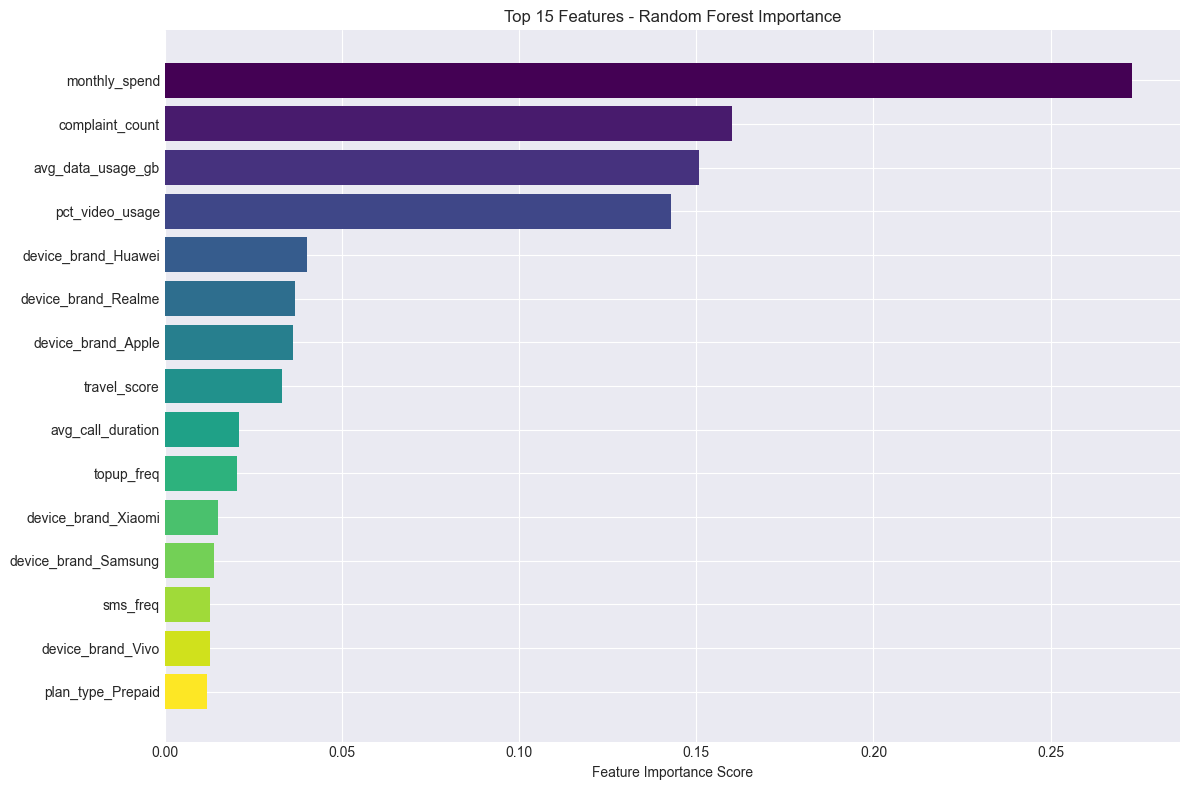

In [27]:
# Visualisasi Random Forest Feature Importance
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, 15))
plt.barh(rf_importance_df['Feature'][:15], rf_importance_df['Importance'][:15], color=colors)
plt.xlabel('Feature Importance Score')
plt.title('Top 15 Features - Random Forest Importance')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

## 6. Permutation Importance

Calculating permutation importance...

=== Top 10 Features berdasarkan Permutation Importance ===
                Feature  Importance_Mean  Importance_Std  Percentage
4         monthly_spend          0.28600        0.006384       30.34
0     avg_data_usage_gb          0.15815        0.004950       16.78
1       pct_video_usage          0.15005        0.005359       15.92
7       complaint_count          0.10665        0.003821       11.32
11  device_brand_Huawei          0.06255        0.001929        6.64
10   device_brand_Apple          0.04775        0.003430        5.07
13  device_brand_Realme          0.04635        0.002933        4.92
5            topup_freq          0.03025        0.002136        3.21
9     plan_type_Prepaid          0.01760        0.001786        1.87
6          travel_score          0.01655        0.000687        1.76


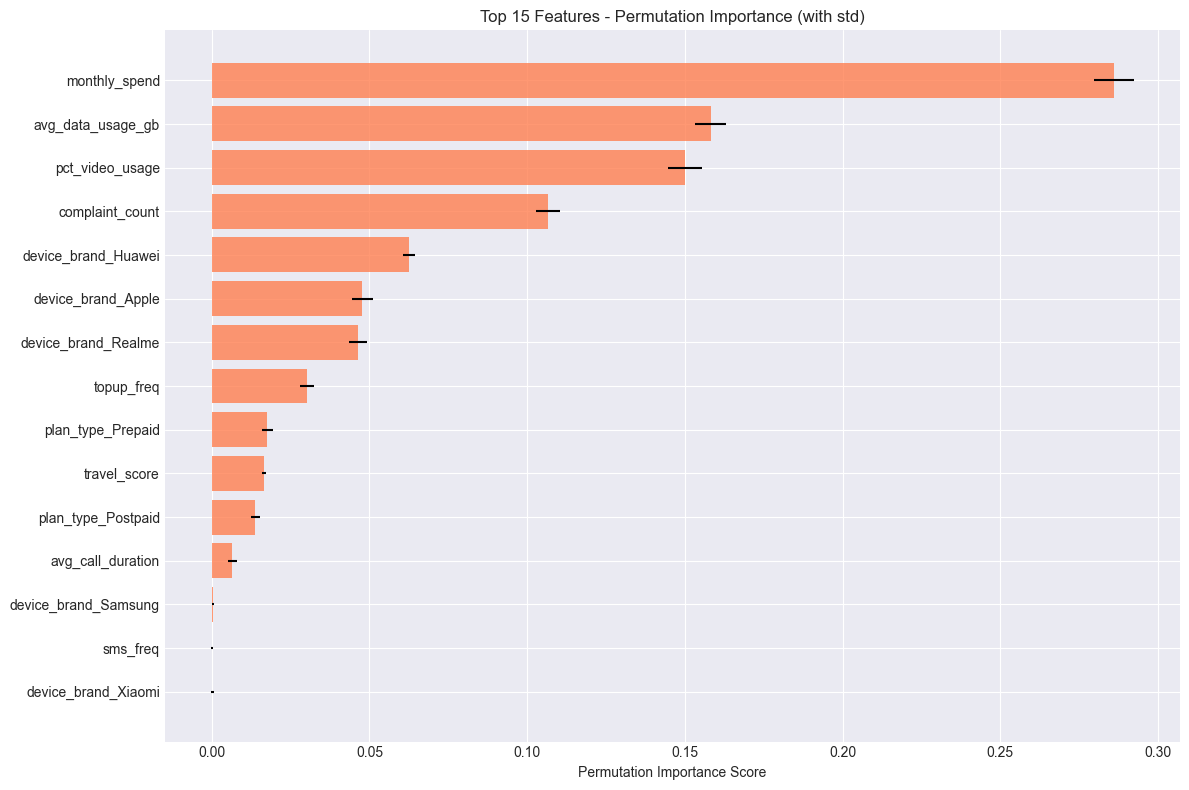

In [28]:
# Calculate permutation importance
print("Calculating permutation importance...")
perm_importance = permutation_importance(
    rf_model, 
    X_test, 
    y_test, 
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Create DataFrame
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std,
    'Percentage': (perm_importance.importances_mean / perm_importance.importances_mean.sum() * 100).round(2)
}).sort_values('Importance_Mean', ascending=False)

print("\n=== Top 10 Features berdasarkan Permutation Importance ===")
print(perm_importance_df.head(10))

# Visualisasi
plt.figure(figsize=(12, 8))
top_15 = perm_importance_df.head(15)
plt.barh(top_15['Feature'], top_15['Importance_Mean'], 
         xerr=top_15['Importance_Std'], color='coral', alpha=0.8)
plt.xlabel('Permutation Importance Score')
plt.title('Top 15 Features - Permutation Importance (with std)')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

## 7. Kombinasi dan Ranking Features

In [29]:
# Gabungkan semua metode
combined_df = pd.DataFrame({
    'Feature': feature_names
})

# Merge correlation
combined_df = combined_df.merge(
    corr_df[['Feature', 'Correlation', 'Percentage']].rename(columns={'Percentage': 'Corr_Pct'}),
    on='Feature'
)

# Merge RF importance
combined_df = combined_df.merge(
    rf_importance_df[['Feature', 'Importance', 'Percentage']].rename(columns={'Importance': 'RF_Importance', 'Percentage': 'RF_Pct'}),
    on='Feature'
)

# Merge permutation importance
combined_df = combined_df.merge(
    perm_importance_df[['Feature', 'Importance_Mean', 'Percentage']].rename(columns={'Importance_Mean': 'Perm_Importance', 'Percentage': 'Perm_Pct'}),
    on='Feature'
)

# Hitung ranking untuk setiap metode
combined_df['Corr_Rank'] = combined_df['Correlation'].rank(ascending=False)
combined_df['RF_Rank'] = combined_df['RF_Importance'].rank(ascending=False)
combined_df['Perm_Rank'] = combined_df['Perm_Importance'].rank(ascending=False)

# Average rank
combined_df['Avg_Rank'] = combined_df[['Corr_Rank', 'RF_Rank', 'Perm_Rank']].mean(axis=1)
combined_df = combined_df.sort_values('Avg_Rank')

print("\n=== Top 15 Features - Kombinasi Semua Metode ===")
print(combined_df.head(15)[['Feature', 'Corr_Pct', 'RF_Pct', 'Perm_Pct', 'Avg_Rank']])


=== Top 15 Features - Kombinasi Semua Metode ===
                 Feature  Corr_Pct  RF_Pct  Perm_Pct   Avg_Rank
4          monthly_spend     27.75   27.29     30.34   1.000000
0      avg_data_usage_gb     24.71   15.08     16.78   2.333333
7        complaint_count      3.71   16.02     11.32   4.666667
11   device_brand_Huawei      4.45    4.02      6.64   4.666667
10    device_brand_Apple      4.76    3.63      5.07   5.333333
13   device_brand_Realme      4.39    3.69      4.92   6.000000
1        pct_video_usage      3.10   14.28     15.92   6.000000
5             topup_freq      3.15    2.02      3.21   9.333333
6           travel_score      2.64    3.31      1.76  10.333333
16   device_brand_Xiaomi      4.08    1.50      0.02  10.500000
2      avg_call_duration      2.89    2.09      0.69  11.000000
14  device_brand_Samsung      3.48    1.40      0.03  11.333333
15     device_brand_Vivo      3.75    1.27     -0.06  12.666667
9      plan_type_Prepaid      2.15    1.18      1.87  

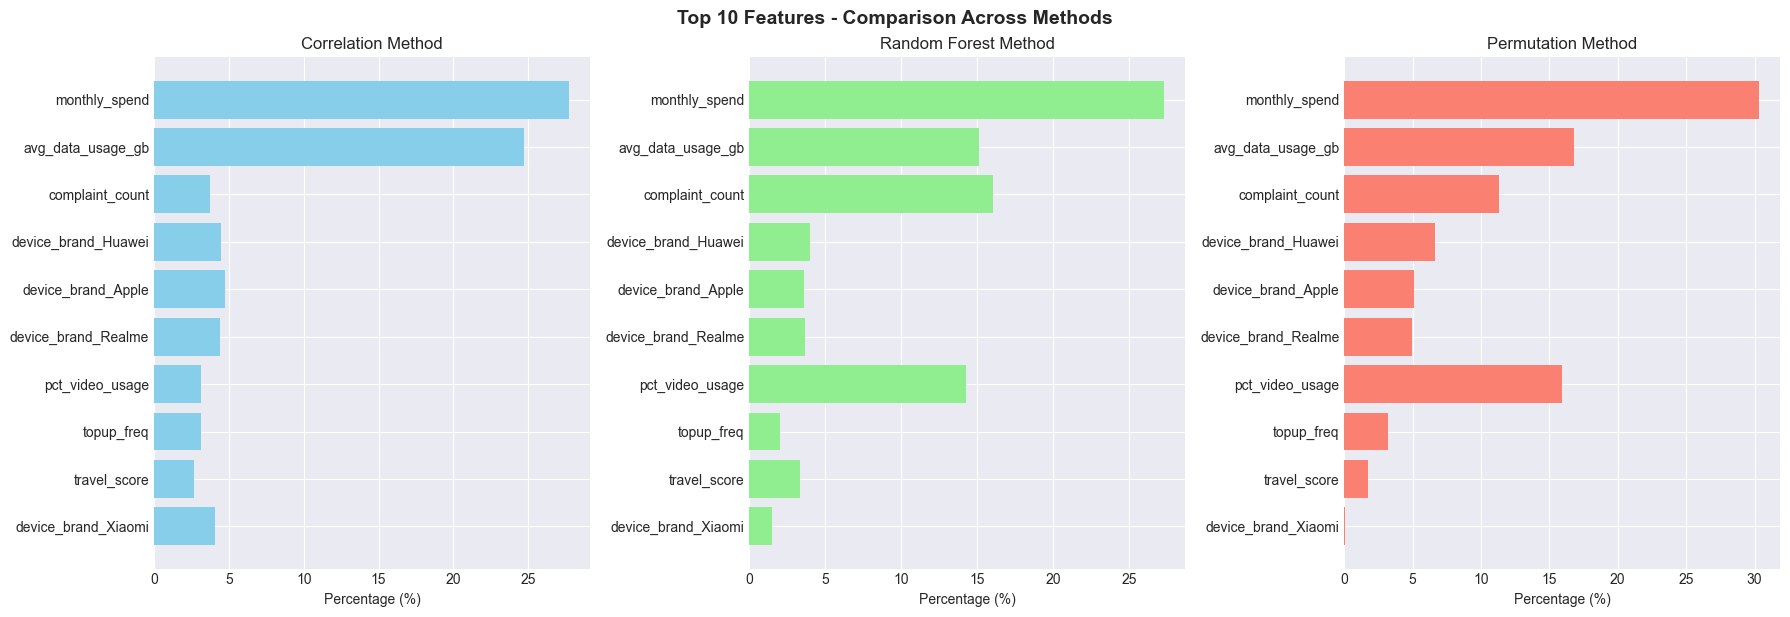

In [30]:
# Visualisasi perbandingan metode untuk top 10 features
top_10_features = combined_df.head(10)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Correlation
axes[0].barh(top_10_features['Feature'], top_10_features['Corr_Pct'], color='skyblue')
axes[0].set_xlabel('Percentage (%)')
axes[0].set_title('Correlation Method')
axes[0].invert_yaxis()

# Random Forest
axes[1].barh(top_10_features['Feature'], top_10_features['RF_Pct'], color='lightgreen')
axes[1].set_xlabel('Percentage (%)')
axes[1].set_title('Random Forest Method')
axes[1].invert_yaxis()

# Permutation
axes[2].barh(top_10_features['Feature'], top_10_features['Perm_Pct'], color='salmon')
axes[2].set_xlabel('Percentage (%)')
axes[2].set_title('Permutation Method')
axes[2].invert_yaxis()

plt.tight_layout()
plt.suptitle('Top 10 Features - Comparison Across Methods', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 8. Feature Selection berdasarkan Threshold

In [31]:
# Pilih fitur dengan persentase di atas threshold tertentu
threshold_pct = 3.0  # Ambil fitur dengan kontribusi > 3%

# Filter berdasarkan RF Importance
selected_features_rf = rf_importance_df[rf_importance_df['Percentage'] >= threshold_pct]

print(f"\n=== Features dengan RF Importance >= {threshold_pct}% ===")
print(selected_features_rf)
print(f"\nTotal selected features: {len(selected_features_rf)}")
print(f"Cumulative percentage: {selected_features_rf['Percentage'].sum():.2f}%")


=== Features dengan RF Importance >= 3.0% ===
                Feature  Importance  Percentage
4         monthly_spend    0.272866       27.29
7       complaint_count    0.160162       16.02
0     avg_data_usage_gb    0.150787       15.08
1       pct_video_usage    0.142751       14.28
11  device_brand_Huawei    0.040153        4.02
13  device_brand_Realme    0.036854        3.69
10   device_brand_Apple    0.036270        3.63
6          travel_score    0.033115        3.31

Total selected features: 8
Cumulative percentage: 87.32%


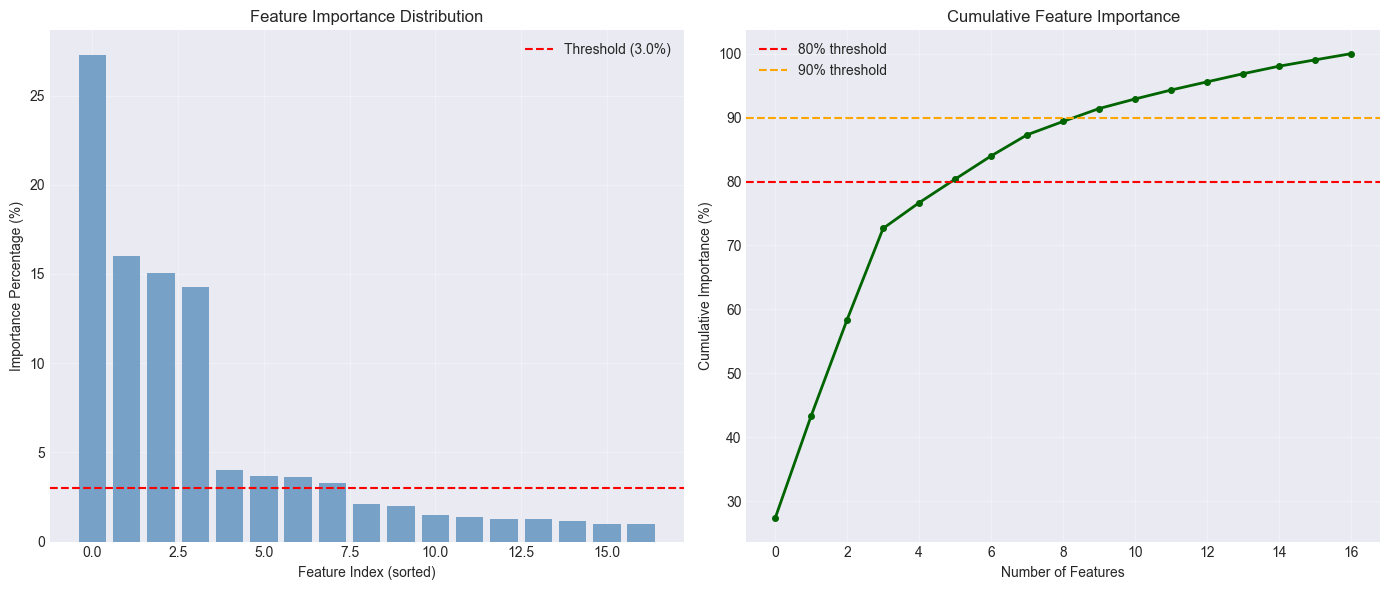


Jumlah fitur untuk mencapai 80% importance: 5
Jumlah fitur untuk mencapai 90% importance: 9


In [32]:
# Cumulative importance plot
rf_importance_sorted = rf_importance_df.sort_values('Importance', ascending=False).copy()
rf_importance_sorted['Cumulative_Pct'] = rf_importance_sorted['Percentage'].cumsum()

plt.figure(figsize=(14, 6))

# Plot 1: Individual importance
plt.subplot(1, 2, 1)
plt.bar(range(len(rf_importance_sorted)), rf_importance_sorted['Percentage'], color='steelblue', alpha=0.7)
plt.axhline(y=threshold_pct, color='r', linestyle='--', label=f'Threshold ({threshold_pct}%)')
plt.xlabel('Feature Index (sorted)')
plt.ylabel('Importance Percentage (%)')
plt.title('Feature Importance Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative importance
plt.subplot(1, 2, 2)
plt.plot(range(len(rf_importance_sorted)), rf_importance_sorted['Cumulative_Pct'], 
         marker='o', linewidth=2, markersize=4, color='darkgreen')
plt.axhline(y=80, color='r', linestyle='--', label='80% threshold')
plt.axhline(y=90, color='orange', linestyle='--', label='90% threshold')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance (%)')
plt.title('Cumulative Feature Importance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Berapa fitur yang dibutuhkan untuk mencapai 80% dan 90%
n_features_80 = (rf_importance_sorted['Cumulative_Pct'] <= 80).sum()
n_features_90 = (rf_importance_sorted['Cumulative_Pct'] <= 90).sum()
print(f"\nJumlah fitur untuk mencapai 80% importance: {n_features_80}")
print(f"Jumlah fitur untuk mencapai 90% importance: {n_features_90}")

## 9. Save Results

In [33]:
# Save combined results
combined_df.to_csv('../data/plot/feature_importance_analysis.csv', index=False)
print("Feature importance analysis saved to '../data/plot/feature_importance_analysis.csv'")

# Save top features (menggunakan average rank)
top_features = combined_df.head(10)['Feature'].tolist()
with open('../data/plot/top_features_for_target_offer.txt', 'w') as f:
    f.write("Top 10 Features untuk Target Offer:\n\n")
    for idx, feat in enumerate(top_features, 1):
        f.write(f"{idx}. {feat}\n")
print("Top features list saved to '../data/plot/top_features_for_target_offer.txt'")

Feature importance analysis saved to '../data/plot/feature_importance_analysis.csv'
Top features list saved to '../data/plot/top_features_for_target_offer.txt'


## 10. Summary dan Kesimpulan

In [34]:
print("="*70)
print("SUMMARY - FEATURE IMPORTANCE ANALYSIS")
print("="*70)
print(f"\nTotal Features Analyzed: {len(feature_names)}")
print(f"\nTop 5 Features (berdasarkan kombinasi ranking):")
for idx, row in combined_df.head(5).iterrows():
    print(f"  {int(row['Avg_Rank'])}. {row['Feature']}")
    print(f"     - Correlation: {row['Correlation']:.4f} ({row['Corr_Pct']:.2f}%)")
    print(f"     - RF Importance: {row['RF_Importance']:.4f} ({row['RF_Pct']:.2f}%)")
    print(f"     - Perm Importance: {row['Perm_Importance']:.4f} ({row['Perm_Pct']:.2f}%)")
    print()

print("\nRekomendasi:")
print(f"  - Gunakan {n_features_80} fitur teratas untuk mencapai 80% explanatory power")
print(f"  - Gunakan {n_features_90} fitur teratas untuk mencapai 90% explanatory power")
print(f"  - Fitur dengan persentase >= {threshold_pct}% sangat signifikan untuk prediksi")
print("="*70)

SUMMARY - FEATURE IMPORTANCE ANALYSIS

Total Features Analyzed: 17

Top 5 Features (berdasarkan kombinasi ranking):
  1. monthly_spend
     - Correlation: 0.5511 (27.75%)
     - RF Importance: 0.2729 (27.29%)
     - Perm Importance: 0.2860 (30.34%)

  2. avg_data_usage_gb
     - Correlation: 0.4909 (24.71%)
     - RF Importance: 0.1508 (15.08%)
     - Perm Importance: 0.1582 (16.78%)

  4. complaint_count
     - Correlation: 0.0737 (3.71%)
     - RF Importance: 0.1602 (16.02%)
     - Perm Importance: 0.1067 (11.32%)

  4. device_brand_Huawei
     - Correlation: 0.0884 (4.45%)
     - RF Importance: 0.0402 (4.02%)
     - Perm Importance: 0.0626 (6.64%)

  5. device_brand_Apple
     - Correlation: 0.0946 (4.76%)
     - RF Importance: 0.0363 (3.63%)
     - Perm Importance: 0.0478 (5.07%)


Rekomendasi:
  - Gunakan 5 fitur teratas untuk mencapai 80% explanatory power
  - Gunakan 9 fitur teratas untuk mencapai 90% explanatory power
  - Fitur dengan persentase >= 3.0% sangat signifikan untuk 